In [2]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

In [4]:
from numba.typed import List
from numba import jit, njit, vectorize

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [6]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [7]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 
@njit()
def get_rng(x):
    n = np.max(x)
    m = np.min(x)
    z = n-m
    return z 

def get_rms(x, axis=None):
    return np.sqrt(np.mean(x ** 2, axis=axis))

def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])

def get_sma(data): 
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return sma_sim, sma_adv, sma_sim_abs, sma_adv_abs

def get_entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

In [8]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

# Feature extraction and Normalization_0_1_mapping on signal

In [9]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    data_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
    data_scaled = data_scaler.fit_transform(win)
    win = data_scaled
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    features.append(get_entropy(win))
    mean_crossing = [mean_crossing_rate(win[:, i]) for i in range(win.shape[1])]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    
    features = np.hstack(features).tolist()
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [10]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [11]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset
   

In [12]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [13]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1]
    X = np.array(X)
    
    Y = dataset.iloc[:, -1]
    Y = np.array(Y)

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    
    return accuracy

In [14]:
mod = {'RF': RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)}

In [15]:
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

Start for win size 3
Features


In [16]:
ACC.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,0.476782,0.456006,0.456006,0.0,1.0,1930.965364,7.228819,75.0,72.0,...,0.301419,0.369484,0.222592,0.387002,0.384233,0.235126,0.199399,0.168864,0.127401,1
1,1,0.466670,0.445833,0.445833,0.0,1.0,1890.012908,7.228819,77.0,82.0,...,0.335752,0.357098,0.222389,0.406192,0.351487,0.218585,0.180685,0.127732,0.133337,1
2,1,0.469601,0.449496,0.449496,0.0,1.0,1901.884042,7.228819,76.0,84.0,...,0.334353,0.334749,0.278142,0.379424,0.317147,0.175670,0.184300,0.115309,0.140016,1
3,1,0.507955,0.491115,0.491115,0.0,1.0,2057.216229,7.228819,50.0,90.0,...,0.341439,0.323987,0.296943,0.382285,0.282576,0.138681,0.173067,0.137085,0.155798,1
4,1,0.508241,0.484555,0.484555,0.0,1.0,2058.376420,7.228819,48.0,94.0,...,0.353515,0.340356,0.287201,0.404683,0.311027,0.153141,0.185786,0.146668,0.140557,1
5,1,0.527015,0.517545,0.517545,0.0,1.0,2134.411185,7.228819,33.0,89.0,...,0.397688,0.387433,0.275099,0.278583,0.305903,0.281350,0.262914,0.145737,0.165491,1
6,1,0.522799,0.518004,0.518004,0.0,1.0,2117.336838,7.228819,43.0,78.0,...,0.396110,0.377313,0.223801,0.282027,0.308262,0.287616,0.268562,0.144660,0.173635,1
7,1,0.532351,0.530424,0.530424,0.0,1.0,2156.020060,7.228819,51.0,59.0,...,0.357812,0.383820,0.182487,0.288349,0.296814,0.287602,0.250660,0.138460,0.175441,1
8,1,0.521058,0.509830,0.509830,0.0,1.0,2110.286074,7.228819,61.0,61.0,...,0.365975,0.271924,0.187877,0.264952,0.282871,0.270598,0.271225,0.146585,0.184908,1
9,1,0.510955,0.509368,0.509368,0.0,1.0,2069.368897,7.228819,73.0,63.0,...,0.372688,0.282330,0.194663,0.290594,0.302654,0.207442,0.284666,0.141074,0.276363,1


In [17]:
GYR.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,0.524750,0.521898,0.521898,0.0,1.0,2125.235624,7.228819,66.0,91.0,...,0.309790,0.575331,0.515350,0.194532,0.610223,0.273595,0.331871,0.498434,0.257163,1
1,1,0.528014,0.528939,0.528939,0.0,1.0,2138.458009,7.228819,66.0,94.0,...,0.289693,0.517762,0.483659,0.160693,0.574384,0.259609,0.312761,0.512587,0.247324,1
2,1,0.514167,0.513302,0.513302,0.0,1.0,2082.376585,7.228819,68.0,96.0,...,0.268780,0.488424,0.486205,0.143631,0.589358,0.263691,0.276508,0.582945,0.271950,1
3,1,0.521770,0.520049,0.520049,0.0,1.0,2113.167680,7.228819,103.0,96.0,...,0.273580,0.485316,0.399448,0.150308,0.525562,0.217669,0.267479,0.560041,0.300004,1
4,1,0.511657,0.501446,0.501446,0.0,1.0,2072.212407,7.228819,97.0,89.0,...,0.284770,0.561209,0.423626,0.176524,0.508171,0.227855,0.227375,0.501234,0.294611,1
5,1,0.521683,0.513135,0.513135,0.0,1.0,2112.817547,7.228819,91.0,74.0,...,0.309707,0.563872,0.410150,0.254863,0.500576,0.304175,0.243715,0.509829,0.273562,1
6,1,0.502780,0.488235,0.488235,0.0,1.0,2036.260068,7.228819,99.0,84.0,...,0.317063,0.522084,0.392532,0.255525,0.484532,0.293789,0.243868,0.491953,0.268379,1
7,1,0.501401,0.490040,0.490040,0.0,1.0,2030.675694,7.228819,80.0,83.0,...,0.301471,0.499842,0.379191,0.274374,0.541145,0.275966,0.257754,0.498301,0.262144,1
8,1,0.500722,0.493532,0.493532,0.0,1.0,2027.924334,7.228819,75.0,81.0,...,0.306845,0.484151,0.382305,0.252324,0.516570,0.284681,0.219353,0.513627,0.309952,1
9,1,0.493745,0.487089,0.487089,0.0,1.0,1999.665315,7.228819,75.0,80.0,...,0.324704,0.432874,0.395699,0.274992,0.440051,0.301818,0.165053,0.513787,0.308133,1


In [18]:
MAG.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,0.491298,0.478834,0.478834,0.0,1.0,1989.757209,7.228819,89.0,80.0,...,0.426673,0.306330,0.342693,0.254241,0.352260,0.257510,0.351615,0.351169,0.253033,1
1,1,0.486024,0.466866,0.466866,0.0,1.0,1968.395960,7.228819,78.0,88.0,...,0.423905,0.344296,0.333051,0.234965,0.411956,0.265520,0.364291,0.370100,0.174727,1
2,1,0.471768,0.446234,0.446234,0.0,1.0,1910.658392,7.228819,74.0,84.0,...,0.428788,0.402646,0.293387,0.221586,0.463803,0.346857,0.404530,0.363902,0.183564,1
3,1,0.476636,0.453516,0.453516,0.0,1.0,1930.374249,7.228819,25.0,80.0,...,0.473883,0.415735,0.218924,0.250620,0.452869,0.381871,0.431962,0.356067,0.263946,1
4,1,0.473170,0.482420,0.482420,0.0,1.0,1916.336550,7.228819,23.0,16.0,...,0.439905,0.427274,0.219320,0.262487,0.404647,0.363649,0.456352,0.321197,0.293061,1
5,1,0.473578,0.497851,0.497851,0.0,1.0,1917.989703,7.228819,130.0,28.0,...,0.379698,0.370472,0.283971,0.279858,0.408258,0.327298,0.415736,0.338714,0.284969,1
6,1,0.495848,0.516889,0.516889,0.0,1.0,2008.182630,7.228819,117.0,30.0,...,0.357475,0.336272,0.295381,0.321900,0.395289,0.279741,0.371460,0.347669,0.264923,1
7,1,0.478023,0.461241,0.461241,0.0,1.0,1935.995160,7.228819,102.0,66.0,...,0.319539,0.342120,0.284793,0.376771,0.441858,0.312540,0.382127,0.360614,0.204960,1
8,1,0.486582,0.473933,0.473933,0.0,1.0,1970.658262,7.228819,88.0,98.0,...,0.281393,0.366535,0.247787,0.407739,0.462271,0.366154,0.406114,0.335171,0.240894,1
9,1,0.508015,0.511809,0.511809,0.0,1.0,2057.460378,7.228819,74.0,50.0,...,0.293347,0.374366,0.229674,0.419471,0.475247,0.374761,0.371378,0.455535,0.266593,1


In [19]:
QUAD.head(10)

,group,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,1,0.517956,0.525942,0.525942,0.0,1.0,2796.962602,7.228819,73.0,71.0,...,0.394945,0.551106,0.471717,0.459209,0.367508,0.306698,0.368150,0.286315,0.240254,1
1,1,0.517187,0.524324,0.524324,0.0,1.0,2792.808434,7.228819,70.0,84.0,...,0.390004,0.581343,0.470018,0.495584,0.305839,0.272333,0.310950,0.208233,0.161654,1
2,1,0.514267,0.529792,0.529792,0.0,1.0,2777.042128,7.228819,65.0,84.0,...,0.452016,0.500304,0.384132,0.577132,0.241834,0.224800,0.341568,0.216095,0.167605,1
3,1,0.515813,0.530462,0.530462,0.0,1.0,2785.389428,7.228819,38.0,102.0,...,0.533070,0.416419,0.317366,0.527090,0.256369,0.178422,0.411727,0.294461,0.244100,1
4,1,0.534583,0.554111,0.554111,0.0,1.0,2886.747460,7.228819,31.0,104.0,...,0.529100,0.414341,0.337087,0.485107,0.326146,0.246329,0.435662,0.327099,0.274559,1
5,1,0.535198,0.541045,0.541045,0.0,1.0,2890.068972,7.228819,44.0,99.0,...,0.454585,0.467318,0.396781,0.436314,0.350963,0.279232,0.413062,0.311482,0.267559,1
6,1,0.542442,0.565185,0.565185,0.0,1.0,2929.186276,7.228819,55.0,94.0,...,0.398805,0.507534,0.418286,0.449565,0.358655,0.286802,0.381143,0.289383,0.250940,1
7,1,0.528604,0.544292,0.544292,0.0,1.0,2854.461559,7.228819,67.0,84.0,...,0.379557,0.504312,0.396264,0.466947,0.313417,0.286267,0.327578,0.253349,0.191188,1
8,1,0.511004,0.493748,0.493748,0.0,1.0,2759.419513,7.228819,80.0,81.0,...,0.421468,0.426599,0.324632,0.478354,0.282931,0.227172,0.356636,0.295970,0.235425,1
9,1,0.505148,0.487318,0.487318,0.0,1.0,2727.798153,7.228819,93.0,91.0,...,0.442727,0.414725,0.318844,0.459497,0.327668,0.195276,0.363621,0.361424,0.257365,1


In [20]:
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.6993006993006993
Model- 2  -  f1 score:  0.7952062037363412
Model- 3  -  f1 score:  0.7296
Model- 4  -  f1 score:  0.7911886186324002
Model- 5  -  f1 score:  0.6503448275862069
Model- 6  -  f1 score:  0.7788888888888889
Model- 7  -  f1 score:  0.48753462603878117
Model- 8  -  f1 score:  0.7092933947772657
Model- 9  -  f1 score:  0.7295726495726496
Model- 10  -  f1 score:  0.7845681119836122
Model- 11  -  f1 score:  0.8296875
Model- 12  -  f1 score:  0.7999371859296482
Model- 13  -  f1 score:  0.7332768839966131
Model- 14  -  f1 score:  0.6659626891939457
Model- 15  -  f1 score:  0.6803811173668255
Model- 16  -  f1 score:  0.5902118334550767
Model- 17  -  f1 score:  0.7421072651198174


0.71747426444581

In [21]:
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5384615384615384
Model- 2  -  f1 score:  0.6411702502643638
Model- 3  -  f1 score:  0.5568
Model- 4  -  f1 score:  0.5993575034419458
Model- 5  -  f1 score:  0.4772413793103448
Model- 6  -  f1 score:  0.6538888888888889
Model- 7  -  f1 score:  0.5346260387811634
Model- 8  -  f1 score:  0.5841013824884793
Model- 9  -  f1 score:  0.5876923076923077
Model- 10  -  f1 score:  0.6264936838511438
Model- 11  -  f1 score:  0.621875
Model- 12  -  f1 score:  0.635678391959799
Model- 13  -  f1 score:  0.4865932825289303
Model- 14  -  f1 score:  0.5656458993312214
Model- 15  -  f1 score:  0.5179731485491554
Model- 16  -  f1 score:  0.5390796201607012
Model- 17  -  f1 score:  0.5359452263217953


0.570742561295987

In [22]:
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5653846153846154
Model- 2  -  f1 score:  0.698625308424392
Model- 3  -  f1 score:  0.7176
Model- 4  -  f1 score:  0.7581459385039009
Model- 5  -  f1 score:  0.5937931034482758
Model- 6  -  f1 score:  0.5988888888888889
Model- 7  -  f1 score:  0.5595567867036011
Model- 8  -  f1 score:  0.685099846390169
Model- 9  -  f1 score:  0.6287179487179487
Model- 10  -  f1 score:  0.7255035848412427
Model- 11  -  f1 score:  0.845
Model- 12  -  f1 score:  0.8435929648241206
Model- 13  -  f1 score:  0.7067456957380751
Model- 14  -  f1 score:  0.7173530447025694
Model- 15  -  f1 score:  0.8198354265915981
Model- 16  -  f1 score:  0.5986121256391527
Model- 17  -  f1 score:  0.7272727272727273


0.6935134121218398

In [23]:
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.3265734265734266
Model- 2  -  f1 score:  0.4342615438843849
Model- 3  -  f1 score:  0.3984
Model- 4  -  f1 score:  0.3955943093162001
Model- 5  -  f1 score:  0.4203448275862069
Model- 6  -  f1 score:  0.45444444444444443
Model- 7  -  f1 score:  0.7119113573407202
Model- 8  -  f1 score:  0.3425499231950845
Model- 9  -  f1 score:  0.26222222222222225
Model- 10  -  f1 score:  0.32570843291225676
Model- 11  -  f1 score:  0.563125
Model- 12  -  f1 score:  0.4959170854271357
Model- 13  -  f1 score:  0.31329381879762913
Model- 14  -  f1 score:  0.3333333333333333
Model- 15  -  f1 score:  0.4707665656128194
Model- 16  -  f1 score:  0.46493791088385683
Model- 17  -  f1 score:  0.45112209965766453


0.42144154712866966

In [24]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy]}

In [25]:
df_accuracy = pd.DataFrame(data=d)

In [26]:
df_accuracy

,ACC,GYR,MAG,QUAD
0,0.717474,0.570743,0.693513,0.421442


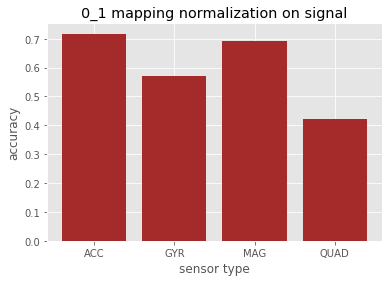

In [27]:
x = ['ACC', 'GYR', 'MAG', 'QUAD']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='brown')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("0_1 mapping normalization on signal")

plt.xticks(x_pos, x)

plt.show()